In [1]:
from math import inf
from pathlib import Path
import csv

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn

## Define a pytorch Dataset object to contain the training and testing data

Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a
wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our
data is in numpy format, which conveniently pytorch has a method for converting to their native format.

In [2]:
class AngleDataset(Dataset):
    def __init__(self, csv_path: Path):
        """Create a PyTorch dataset from CSV data.

        Args:
            csv_path (Path): kinematics data file
        """
        df = pd.read_csv(csv_path)
        length = len(df)

        # The network takes a sinusoidal signal as an input
        sim_time = 10
        freq = 1
        time = torch.linspace(0, sim_time, length)
        sin_signal = torch.sin(2 * torch.pi * freq * time)

        # data order = sin (1), angles (4*3*2), torso (2*2), touch_sens (4)
        x_data = []
        y_data = []

        for sin_val, i in zip(sin_signal, range(length)):
            x_data.append(torch.hstack([sin_val, torch.tensor(df.iloc[i])]))
            # No need to predict/output touch sensor values
            y_data.append(df.iloc[i + 1][:-4] if i < length - 1 else df.iloc[0][:-4])

        self.x_data: torch.Tensor = torch.vstack(x_data).type(torch.float32)
        self.y_data: torch.Tensor = torch.tensor(y_data).type(torch.float32)
        self.length: int = len(self.x_data)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.x_data[index], self.y_data[index]

    def __len__(self) -> int:
        return self.length

## Define training methods for the model

These methods use an initialized model and training data to iteratively perform the forward and backward pass of
optimization. Aside from some data reformatting that depends on the input, output, and loss function, these methods will
always be the same for any shallow neural network.

In [3]:
def train_batch(
    model: nn.Module,
    x: torch.Tensor,
    y: torch.Tensor,
    optimizer: optim.Optimizer,
    criteria: nn.Module,
) -> float:
    """Train the given model on a single batch of data.

    Args:
        model (nn.Module): model to train
        x (torch.Tensor): input data
        y (torch.Tensor): labeled output data
        optimizer (optim.Optimizer): SGD-based optimzier
        criteria (nn.Module): loss function

    Returns:
        float: mean loss for the batch
    """

    model.train()

    # Compute output
    y_predict = model(x)

    # Compute loss
    loss = criteria(y_predict, y)

    # Zero out current gradient values
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data.item()


def train_loop(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    critera: nn.Module,
    num_epochs: int,
) -> list[float]:
    """Train the model.

    Args:
        model (nn.Module): model to train
        loader (DataLoader): training data
        optimizer (nn.Module): SGD-based optimizer
        critera (nn.Module): loss function
        num_epochs (int): number of epochs to train

    Returns:
        list[float]: mean loss for each batch in each epoch
    """

    losses = []

    for _ in range(num_epochs):
        for x, y in loader:
            loss = train_batch(model, x, y, optimizer, critera)
            losses.append(loss)

    return losses

## Define inference methods for the model

These methods are like training, but we don't need to update the parameters of the model anymore because when we call
the test() method, the model has already been trained. Instead, this method just calculates the predicted y values and
returns them, AKA the forward pass.

In [4]:
def batch_inference(model: nn.Module, x: torch.Tensor) -> torch.Tensor:
    model.eval()
    return model(x)


def inference(model: nn.Module, dataset: AngleDataset) -> torch.Tensor:
    """Compute model outputs for the given data.

    Args:
        model (nn.Module): trained model
        dataset (AngleDataset): data to test

    Returns:
        torch.Tensor: computed output values
    """
    loader = DataLoader(dataset, batch_size=len(dataset))
    predictions = [batch_inference(model, x) for x, _ in loader]
    return torch.concat(predictions)

## Define Model Architecture
- 33 inputs = 3 joint angles per leg, 4 legs, 2 DOF per joint. 4 touch sensors. 1 sine timestamp.
- 28 outputs = *same as above, except just the joint angles*


In [5]:
class GaitModel(nn.Module):
    def __init__(self, layer_sizes: list[int], batch_norm: bool, dropout: float):
        """A PyTorch model trained to output new joint angles.

        Args:
            layer_sizes (list[int]): number of neurons per layer
            batch_norm (bool): flag for using batch normalization
            dropout (float): flag/value for using dropout
        """
        super(GaitModel, self).__init__()

        hidden_layers = []

        # Loop over layer_sizes and create linear->relu[->batchnorm][->dropout] layers
        for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes):
            # Required layers
            layers = [nn.Linear(nlminus1, nl), nn.ReLU()]

            # Optional batch normalization layer
            if batch_norm:
                layers.append(nn.BatchNorm1d(nl))

            # Optional dropout layer
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            hidden_layers.append(nn.Sequential(*layers))

        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

## Define Run function

In [6]:
def train(
    dataset: AngleDataset,
    num_epochs: int,
    batch_size: int,
    learning_rate: float,
    layer_sizes: list[int],
    batch_norm: bool,
    dropout: float,
) -> tuple[nn.Module, list[float]]:
    """Train a model on the given dataset.

    Args:
        dataset (AngleDataset): kinematics dataset
        layer_sizes (list[int]): neurons per layer
        batch_norm (bool): batch normalization flag
        dropout (float): dropout value (0 for no dropout)
        num_epochs (int): number of training epochs
        batch_size (int): training batch size
        learning_rate (float): training learning rate

    Returns:
        tuple[nn.Module, list[float]]: model and training losses
    """

    data_loader = DataLoader(dataset, batch_size, shuffle=True)
    model = GaitModel(layer_sizes, batch_norm, dropout)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    losses = train_loop(
        model=model,
        loader=data_loader,
        optimizer=optimizer,
        critera=criterion,
        num_epochs=num_epochs,
    )

    return model, losses

In [9]:
DATA_DIR = Path("KinematicsData/")
FIGURE_DIR = Path("Figures/")
MODEL_OUTPUT_DIR = Path("ModelOutputs/")
MODEL_DIR = Path("Models/")

df = pd.read_csv(next(DATA_DIR.glob("*_kinematic.csv")))

# We only need the first 28 columns (ignore the touch sensors for output)
CSV_HEADER = df.columns[:28]
CSV_HEADER

Index(['FL A1 DF 1', 'FL A1 DF 2', 'FL A2 DF 1', 'FL A2 DF 2', 'FL A3 DF 1',
       'FL A3 DF 2', 'FR A1 DF 1', 'FR A1 DF 2', 'FR A2 DF 1', 'FR A2 DF 2',
       'FR A3 DF 1', 'FR A3 DF 2', 'BL A1 DF 1', 'BL A1 DF 2', 'BL A2 DF 1',
       'BL A2 DF 2', 'BL A3 DF 1', 'BL A3 DF 2', 'BR A1 DF 1', 'BR A1 DF 2',
       'BR A2 DF 1', 'BR A2 DF 2', 'BR A3 DF 1', 'BR A3 DF 2', 'SP A1 DF 1',
       'SP A1 DF 2', 'SP A2 DF 1', 'SP A2 DF 2'],
      dtype='object')

Processing the 'canter' dataset.
Final loss for canter: 0.01043137438595295
Processing the 'trot' dataset.
Final loss for trot: 0.008609442775486968
Processing the 'gallop' dataset.
Final loss for gallop: 0.010747340468224138


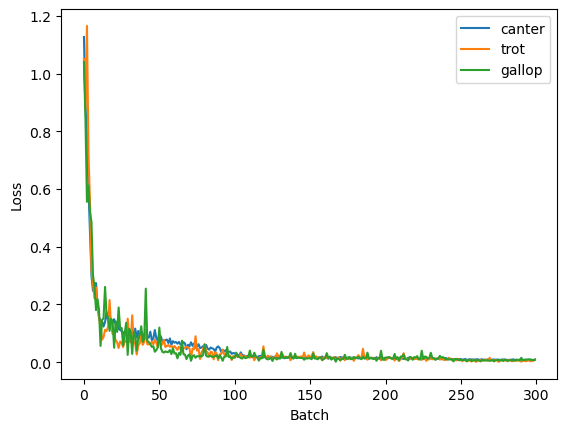

In [10]:
datasets = {
    f.stem.split("_")[0]: AngleDataset(f) for f in DATA_DIR.glob("*_kinematic.csv")
}

# Model hyperparameters
layer_sizes = [33, 31, 30, 28]

# Training hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.01

for gait_name in datasets:

    dataset = datasets[gait_name]

    print(f"Processing the '{gait_name}' dataset.")

    model, losses = train(
        dataset,
        num_epochs,
        batch_size,
        learning_rate,
        layer_sizes,
        batch_norm=False,
        dropout=0,
    )

    predictions = inference(model, dataset)

    # Save the outputs to a csv for quicker comparisons later
    with open(MODEL_OUTPUT_DIR / f"{gait_name}_output.csv", "w") as csvfile:

        writer = csv.writer(csvfile)

        writer.writerow(CSV_HEADER)

        for row in predictions:
            writer.writerow(row.tolist())

    torch.save(model, MODEL_DIR / f"{gait_name}_model.pt")

    final_loss = sum(losses[-100:]) / 100

    print(f"Final loss for {gait_name}: {final_loss}")

    plt.plot(losses, label=gait_name)

plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.savefig(FIGURE_DIR / f"losses.png", facecolor="white")

## Sanity Check Data By Plotting

In [ ]:

kinematics = sorted([f for f in DATA_DIR.glob("*_kinematic.csv") if f.is_file()])
outputs = sorted([f for f in MODEL_OUTPUT_DIR.glob("*_output.csv") if f.is_file()])

for actual, pred in zip(kinematics, outputs):

    dfa = pd.read_csv(actual)
    dfp = pd.read_csv(pred)

    columns = dfp.columns
    num_cols = len(columns)

    fig, axes = plt.subplots(
        num_cols // 2,
        2,
        figsize=(16, 64),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )

    gait_name = actual.stem.split("_")[0]

    fig.suptitle(gait_name, fontsize=24)

    for col, ax in zip(columns, axes.flatten()):
        ax.plot(dfa[col], label="Actual")
        ax.plot(dfp[col], label="Prediction")
        ax.set_title(col)
        ax.legend()

    fig.savefig(FIGURE_DIR / f"{gait_name}_comparison.png", facecolor="white")

In [ ]:
# !jupytext --set-formats ipynb, py:percent gait_model.ipynb